# Code de création de data frame pour la catégorie archimedean

## I) Importation des bibliothèques

C:\Users\manip_nco\Documents\projet_multi_2425\pyNanoMatBuilder



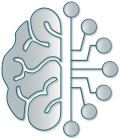

**Start at:** Wednesday 27 November 2024, 17:49:12  
**Hostname:** insa-03437 (Windows)

<p style="text-align: center"><img width="800px" src="./styles/svg/pyNanoMatBuilder_banner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [20]:
##################
# Initialization #
##################

import os
import sys

print(os.getcwd())
cwd0 = './styles/'
sys.path.append(cwd0)

import visualID as vID
from visualID import  fg, hl, bg
vID.init(cwd0)

import numpy as np
import ase
from ase.io import write
from ase.visualize import view

import pyNanoMatBuilder.utils as pNMBu
import importlib
import pandas as pd

from pyNanoMatBuilder import platonicNPs as pNP

import importlib
importlib.reload(pNP)
importlib.reload(pNMBu)

from pyNanoMatBuilder import archimedeanNPs as aNP

## II) Définition des fonctions nécessaires à la creation du data frame 

### Définition de la fonction clean

**Cette fonction a pour but de supprimer la ligne en trop des fichiers xyz que on va creer** 

In [21]:
def clean_xyz(filename):
    dtype = {'names': ('element', 'x', 'y', 'z'),
             'formats': ('U2', float, float, float)}    
    element,x,y,z=np.loadtxt(filename,unpack=True,skiprows=2 , usecols=(0, 1, 2, 3), dtype=dtype)
    outfile=os.path.dirname(filename)+'/'+os.path.basename(filename).split('.')[0]+'.xyz'
    nb_atoms=len(x)
    line2write=str(nb_atoms)+'\n'
    line2write+='\n'
    for i in range(nb_atoms):
        line2write+=str(element[i])+'\t %.8f'%x[i] + '\t %.8f'%y[i] + '\t %.8f'%z[i] +'\n'
    with open(outfile,'w') as file:
        file.write(line2write)
    return outfile

### Définition de la fonction Moment d'inertie

**Cette fonction a pour but de donner la liste des moments d'inertie par rapport à trois axes principaux**

In [22]:
def fmom_inertie(model):
    
        # model.get_moments_of_inertia() : Cette méthode est censée retourner les moments d'inertie du modèle.
        # Les moments d'inertie sont des quantités physiques mesurant la répartition de la masse par rapport à trois axes principaux. 
        # Ils sont généralement donnés en unités de amu⋅A˚2amu⋅A˚2 (masse atomique unifiée multipliée par le carré de la longueur en angströms).
        # La variable model.moi contient ces valeurs, souvent sous la forme d'un tableau ou d'une liste de trois valeurs correspondant aux moments d'inertie autour des trois axes principaux.
        model.moi = model.get_moments_of_inertia()  # en amu*angstrom**2
        # Pour arrondir chaque élément à deux décimales
        model.moi = [round(x, 2) for x in model.moi]
    
        return model.moi
        

**Autres possibilités avec le moment de inertie que on exploitra pas mais qui peuvent être utiles**

In [23]:
## model.get_masses() : Cette méthode retourne les masses des atomes du modèle. Typiquement, ces masses sont données en unités de masse atomique unifiée (amu).
## La variable model.masses est une liste ou un tableau contenant les masses de chaque atome dans le modèle.
#model.masses = model.get_masses()

## model.masses.sum() : Calcule la somme totale des masses de tous les atomes dans le modèle. Cela donne la masse totale du modèle, notée model.M
#model.M = model.masses.sum()

## model.moi / model.M : Divise les moments d'inertie par la masse totale pour obtenir les moments d'inertie normalisés. 
## Ces valeurs sont donc les moments d'inertie par unité de masse, ce qui peut être utile pour comparer des modèles de tailles différentes ou pour des calculs supplémentaires.
#model.moiM = model.moi/model.M

## np.sqrt(5 * model.moiM) : Calcule la racine carrée de cinq fois les moments d'inertie normalisés. Ce calcul est basé sur une approximation
## spécifique pour estimer les dimensions du modèle, généralement utilisée dans des contextes où les moments d'inertie sont utilisés pour déterminer la taille de l'objet.
## Cette formule peut être spécifique à un certain type de modèle ou d'application.
#model.dim = 2*np.sqrt(5*model.moiM)

      
#return model.moi.sum()  # Retourne la somme des moments d'inertie pour un usage simplifié

### Fonction extraction de pararmètre

In [24]:
import pandas as pd

def extract_parameters( Element, Shape, qmin, qmax, qstep, b_iso, df):
    # Filtrer le DataFrame en fonction des paramètres donnés
    filtered_df = df[
        (df['Element'] == Element) &
        (df['Shape'] == Shape) &
        (df['qmin'] == qmin) &
        (df['qmax'] == qmax) &
        (df['qstep'] == qstep) &
        (df['b_iso'] == b_iso)
    ]
    
    # Extraire les colonnes Size_parameters, q, et Intensities sous forme de listes
    size_parameters = filtered_df['Size_parameters'].tolist()
    intensities = filtered_df['Intensities'].tolist()
    
    # Convertir les listes de Size_parameters en liste des premiers éléments (car on veut pas [3,0,0] etc mais juste [3]
    size_parameters = [t[0] for t in size_parameters]

    return size_parameters, intensities

# Exemple d'utilisation
# Supposez que votre DataFrame est stocké dans la variable df
#size_parameters,intensities = extract_parameters('Ag', "cuboctahedron", 0.01, 20, 0.01, 0.1, df)

### Fonction générale polydispersité

In [25]:
import os
from pathlib import Path
from scipy.stats import norm,cauchy
import numpy as np
import matplotlib.pyplot as plt



def polydis (Element,Shape,qmin,qmax,qstep,biso,esd,mean,df="stage/Base_de_donnees_finale/fichier_global.pk") :

    
    ############################## PARAMETERS FOR MODEL GENERATION ##########################################################
    
    mean=mean
    esd=esd
    size_parameters, intensities = extract_parameters(Element, Shape,qmin,qmax,qstep,biso,df)
    y=norm.pdf(size_parameters,mean,esd)
   
    #################################### Weighted summation of contributions to get average S(q) ########################    
    # Mutliply each S(q) by its corresponding weight
    index=0
    taille=int((qmax - qmin) / qstep) + 1
    iq_pol=np.zeros(taille)
    for weight in y:
       
        ws=weight*np.array(intensities[index])
        iq_pol+=ws
        index+=1
    
    
    iq_pol=iq_pol.tolist()
    
    
    return iq_pol

### Définition de la fonction de gestion des datas frame pour la catégorie des solides archimeadean

**Cette fonction a pour but de creer un data frame de une ligne contenant les arguments que on a donné**

In [27]:
def fonction_gestion_dataframe_shapes_archimedean(element,forme,distance,couche,mean,esd,qmin=0.01,qmax=20,qstep=0.01,biso=0.01,endroit_fich_xyz='tempxyz.xyz'):
    """
    forme (cuboctahedron, truncated-tetrahedron, truncated-octahedron, truncated-cube bientot dispo mais pas encore) -- string
    element (ex Au )-- string
    distance = distance entre plus proche voisin -- float
    couche = liste de longueur 3 => [nbr couche voulu,0,0] qui donne le nombre de couche pour former le solide , equivalent de taille --list integer
    qmin -- list 
    qmax -- list 
    qstep -- list 
    biso : pour simuler la vibration atomique et avoir des modèles plus réalistes -- list
    endroit_fich_xyz =  l'endroit ou on veut enregister notre fichier xyz qui sera creé pui supprimé durant l'exécution de la fonction --string
    """
    #on importe les bibliothèques utiles
    
    from pyNanoMatBuilder import crystalNPs as cyNP
  
    import numpy as np

    import importlib
    from pyNanoMatBuilder import archimedeanNPs as aNP
    from pyNanoMatBuilder import platonicNPs as pNP
    from pyNanoMatBuilder import utils as pNMBu
    from ase.io import write, read
    
    # Entrer l'endroit ou on veut enregister notre fichier xyz 
    fich_xyz=f"{endroit_fich_xyz}"

    
    # Création du DataFrame vide (que on viendra remplir dans la suite ) avec les colonnes spécifiées
    df = pd.DataFrame(columns=["Solid_class","Element", "Shape", "Distance","Size_parameters","data_xyz","Eq_Radius","moment_of_inertia","n_Atoms","polydispersity","qmin","qmax","qstep","b_iso","q","Intensities"])

    #Disjonction de cas selon les arguments (plus précisément la forme) que ont a rentés
    if forme != "cuboctahedron" and forme != "truncated_tetrahedron" and forme != "truncated_octahedron" and forme !="truncated_cube" :
        print("La forme donnée n'est pas dans la classe des solides archimedean")
              

    #cas pour le cuboctahedron
    if forme == "cuboctahedron" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        cubo = aNP.fccCubo(f"{element}",distance,couche[0],aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write(fich_xyz, cubo.NP)
        #On garde le rayon tq toute la particule rentre dans une sphère de ce rayon
        try :
            r=cubo.radiusCircumscribedSphere()
        except :
            r=0
       
        n_Atoms=cubo.nAtoms
        

    
    #cas pour le truncated_tetrahedron 
    if forme == "truncated_tetrahedron" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        trTd = aNP.fccTrTd(f"{element}",distance,couche[0],aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write(fich_xyz, trTd.NP)
        #On garde le rayon tq toute la particule rentre dans une sphère de ce rayon
        try :
            r=trTd.radiusCircumscribedSphere()
        except :
            r=0
       
        n_Atoms=trTd.nAtoms
       
    
       
    #cas pour le truncated_octahedron
    if forme == "truncated_octahedron" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction
        trOh = aNP.fccTrOh(f"{element}",distance,couche[0],aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write(fich_xyz, trOh.NP)
        #On garde le rayon tq toute la particule rentre dans une sphère de ce rayon
        try :
            r=trOh.radiusCircumscribedSphere()
        except :
            r=0
       
        n_Atoms=trOh.nAtoms
        
       
      

    #cas pour le truncated_cube, pour le moment pas dispo
    if forme == "truncated_cube" :

        #si c'est bien cette forme alors on creer un fichier xyz qui prends en compte les arguments de la fonction 
        trCube = aNP.fccTrCube(f"{element}",distance,couche[0],aseView=False,thresholdCoreSurface = 0.,skipSymmetryAnalyzis = True,noOutput = True)
        write(fich_xyz, trCube.NP)
        #On garde le rayon tq toute la particule rentre dans une sphère de ce rayon
        try :
            r=trCube.radiusCircumscribedSphere()
        except :
            r=0
       
        n_Atoms=trCube.nAtoms
       
        
       

    #On utilise la fonction Clean sur le fichier xyz que on vient de creer 
    xyz_file=fich_xyz
    xyz_file=clean_xyz(xyz_file)

    # Calcul du moment d'inertie en utilisant le modèle
    structure = read(fich_xyz)  # Lecture de la structure à partir du fichier xyz
    Mom_inertie = fmom_inertie(structure)
    
    # On calcul I(q) avec la fonction debyecalculator et on rentre les tableau numpy générés dans les variable Q et I
    from debyecalculator import DebyeCalculator
    
    calc = DebyeCalculator(qmin=qmin,qmax=qmax,qstep=qstep,device='cuda',biso=biso)
    Q, I = calc.iq(structure_source=xyz_file)

    ###### supression du fichier xyz pour garder seulement le nom
    os.remove(fich_xyz)


    #On rentre nos valeurs dans des variables 
    #df_pol = pd.read_pickle("stage/Base_de_donnees_finale/fichier_global.pk")
    Q=Q
    Distance =distance
    Element= f"{element}"
    Forme=f"{forme}"
    Type_solide= "Archimedean"
    Rayon=r
    moment_inertie= Mom_inertie
    Qmin=qmin
    Qmax=qmax
    Qstep=qstep
    Biso=biso
    N_Atoms=n_Atoms
    Couche=couche
    XYZ=structure

    if esd==0 :
        Polydispersity=list([0,0])
        Intensite=I
    else :
        #On rentre nos valeurs dans des variables 
        df_pol = pd.read_pickle("stage/Base_de_donnees_finale/fichier_global.pk")
        Polydispersity=list([mean,esd])
        Intensite=polydis(element,forme,qmin,qmax,qstep,biso,esd,mean,df_pol)
        
    
    print(type(moment_inertie))
    # On ajout une ligne au DataFrame (avec ce qu'on voulait dedans comme données) en utilisant loc
    df.loc[len(df)] = [Type_solide,Element, Forme, Distance, Couche,XYZ,Rayon, moment_inertie,N_Atoms,Polydispersity,Qmin,Qmax,Qstep,Biso, Q,Intensite]
    
    
    return df  

### Definition de la fonction qui génère les fichier pk pour la classe Archimedean

**On utilise des boucles afin de parcourir toutes les formes, les éléments et le nombre de couche souhaitées.**
**On peut remarqué que à chaque élément il y a une seule distance associée, donc on ne parcours que les éléments dans la boucle**
**et on leurs associes leurs distance respective**

**On effectue ici la concaténation des data frame générés par la fonction d'haut dessus**

In [28]:
def generation_fichier_pk_archimedean(esd_list,forme,couche,nbr_elem,List_qmax,List_qmin,List_qstep,List_biso,lieu_fich_xyz,fichier_intermediaire,fichier_sortie):
    

    # Création du data frame vide (df_concatenated) que on va remplir au fur et à mesure
    df_concatenated  = pd.DataFrame(columns=["Solid_class","Element", "Shape", "Distance","Size_parameters","data_xyz","Eq_Radius","moment_of_inertia","n_Atoms","polydispersity","qmin","qmax","qstep","b_iso","q","Intensities"])


    # On effectue donc les boucles imbriquées
    for f in  forme :
        for s in couche:
            m=s[0]
            for i in range (0,nbr_elem):
                for qmin in List_qmin:
                    for qmax in List_qmax:
                        for qstep in List_qstep:
                            for biso in List_biso:
                                for esd in esd_list:  
                                    
                                    # Création du data frame d'une ligne avec la fonction de gestion des datas frame , et contenant les éléments de la boucle en cours
                                    df_ligne = fonction_gestion_dataframe_shapes_archimedean(liste_element[i],f,liste_distance[i],s,m,esd,qmin,qmax,qstep,biso,lieu_fich_xyz)
                                    # Concaténation du data frame globale avec la data frame d'une ligne
                                    df_concatenated = pd.concat([df_concatenated , df_ligne])


        # Enregistrement forme par forme lors de grosses boucle pour garder certaines choses meme si cela crash
        df_concatenated.to_pickle(fichier_intermediaire%f)

        


    #Sauvegarder le DataFrame en CSV avec tabulation
    df_concatenated.to_pickle(fichier_sortie)


## III) Création du data frame 

**Variables à changer pour les utilisateurs**

In [29]:
# Création de la liste des couches (à changer en fonction de ce que l'on veut jusqu'a ? apres c'est plus gros que 5nm de diamètre)
couche = [[5,0,0]]
#,[3,0,0],[4,0,0],[5,0,0],[6,0,0],[7,0,0],[8,0,0],[9,0,0],[10,0,0],[11,0,0],[12,0,0],[13,0,0],[14,0,0],[15,0,0],[16,0,0],[17,0,0],[18,0,0],[19,0,0],[20,0,0],[21,0,0],[22,0,0]
# Création de la liste des formes, avec liste_de_toutes_les_formes= ["cuboctahedron", "truncated_tetrahedron", "truncated_octahedron", "truncated_cube"] 
forme= [ "cuboctahedron"] #( à changer en fonction de ce que l'on veut (en prenant dans les elements de la liste_de_toutes_les_formes)

# Création des listes d'éléments (liste_element) et de distances (liste_distance
dtype={"names":("atom","distance"),"formats":('U2',float)} #juste pour avoir la liste des elements et des distances de dessous
liste_element,liste_distance=np.loadtxt("atom_latt2.txt",unpack=True,skiprows=1,usecols=[0,1],dtype=dtype)


# Création d'une variable nbr_elem pour parcourir la liste des éléments que de 0 à un certain nombre. 
# Si on veut parcourir toute la liste des éléments, nbr_elem =len(liste_element)
nbr_elem=3

#création de la liste  esd

esd_list=[0,0]

#création des listes qmin, qmax, qstep et biso
List_qmin=[0.01]
List_qmax=[20]
List_qstep=[0.01]
List_biso=[0.1]


# endroit ou on veut enregister notre fichier xyz qui sera creé pui supprimé durant l'exécution de la fonction
lieu_fich_xyz="stage/xyz_tempo/tempo.xyz"

#Nom du fichier qui enregistre forme par forme dans le boucle pour sauvegarder les datas frame petit a petit au cas ou en cas de bug
fichier_intermediaire='stage/Base_de_donnees_sauvegarde/%s.pk'

# Nom du fichier csv de sortie 
fichier_sortie='stage/Base_de_donnees/test.pk'

print(len(forme)*nbr_elem*len(couche)*len(List_qmin)*len(List_qmax)*len(List_qstep)*len(List_biso)*len(esd_list),"lignes attendues dans le data frame")

6 lignes attendues dans le data frame


**Appel de la fonction**

In [30]:
%time generation_fichier_pk_archimedean(esd_list,forme,couche,nbr_elem,List_qmax,List_qmin,List_qstep,List_biso,lieu_fich_xyz,fichier_intermediaire,fichier_sortie)

C:\Users\manip_nco\AppData\Local\Temp\ipykernel_19248\2873729978.py:114: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator(qmin=qmin,qmax=qmax,qstep=qstep,device='cuda',biso=biso)


<class 'list'>


C:\Users\manip_nco\AppData\Local\Temp\ipykernel_19248\326899079.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concatenated = pd.concat([df_concatenated , df_ligne])
C:\Users\manip_nco\AppData\Local\Temp\ipykernel_19248\2873729978.py:114: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator(qmin=qmin,qmax=qmax,qstep=qstep,device='cuda',biso=biso)


<class 'list'>


C:\Users\manip_nco\AppData\Local\Temp\ipykernel_19248\2873729978.py:114: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator(qmin=qmin,qmax=qmax,qstep=qstep,device='cuda',biso=biso)


<class 'list'>


C:\Users\manip_nco\AppData\Local\Temp\ipykernel_19248\2873729978.py:114: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator(qmin=qmin,qmax=qmax,qstep=qstep,device='cuda',biso=biso)


<class 'list'>


C:\Users\manip_nco\AppData\Local\Temp\ipykernel_19248\2873729978.py:114: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator(qmin=qmin,qmax=qmax,qstep=qstep,device='cuda',biso=biso)


<class 'list'>


C:\Users\manip_nco\AppData\Local\Temp\ipykernel_19248\2873729978.py:114: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator(qmin=qmin,qmax=qmax,qstep=qstep,device='cuda',biso=biso)


<class 'list'>
CPU times: total: 1min 35s
Wall time: 26.5 s


## IV) Affichage du Data frame creer

**On lit le fichier pk que on a enregistré plus haut et on l affiche**

In [31]:
# On rentre la lecture du fichier dans la variable data
data = pd.read_pickle(fichier_sortie)

# On indexe la data frame comme il faut
data.index=np.arange(data.shape[0])

# On affiche le résultat final
data.shape
data

,Solid_class,Element,Shape,Distance,Size_parameters,data_xyz,Eq_Radius,moment_of_inertia,n_Atoms,polydispersity,qmin,qmax,qstep,b_iso,q,Intensities
0,Archimedean,Ag,cuboctahedron,2.888885,"[5, 0, 0]","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('A...",14.444424,"[4277896.74, 4277896.74, 4277896.74]",561,"[0, 0]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[346381860.0, 342713700.0, 336674530.0, 328374..."
1,Archimedean,Ag,cuboctahedron,2.888885,"[5, 0, 0]","(Atom('Ag', [0.0, 0.0, 0.0], index=0), Atom('A...",14.444424,"[4277896.74, 4277896.74, 4277896.74]",561,"[0, 0]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[346381860.0, 342713700.0, 336674530.0, 328374..."
2,Archimedean,Al,cuboctahedron,2.852398,"[5, 0, 0]","(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",14.261990,"[1043189.97, 1043189.97, 1043189.97]",561,"[0, 0]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[26495892.0, 26221200.0, 25768830.0, 25146870...."
3,Archimedean,Al,cuboctahedron,2.852398,"[5, 0, 0]","(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",14.261990,"[1043189.97, 1043189.97, 1043189.97]",561,"[0, 0]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[26495892.0, 26221200.0, 25768830.0, 25146870...."
4,Archimedean,Au,cuboctahedron,2.883758,"[5, 0, 0]","(Atom('Au', [0.0, 0.0, 0.0], index=0), Atom('A...",14.418791,"[7783709.98, 7783709.98, 7783709.98]",561,"[0, 0]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[977820000.0, 967510460.0, 950535400.0, 927202..."
5,Archimedean,Au,cuboctahedron,2.883758,"[5, 0, 0]","(Atom('Au', [0.0, 0.0, 0.0], index=0), Atom('A...",14.418791,"[7783709.98, 7783709.98, 7783709.98]",561,"[0, 0]",0.01,20,0.01,0.1,"[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.0...","[977820000.0, 967510460.0, 950535400.0, 927202..."


## V) Vérification et analyse de nos données que l'on vient de creer

**Nous allons tracer les distribution des élements et des formes de notre data frame**

**                  Remarque : si on veut une base de données cohérente, il faut le meme nombre de forme en tout et le meme nombre d'éléments par forme également**

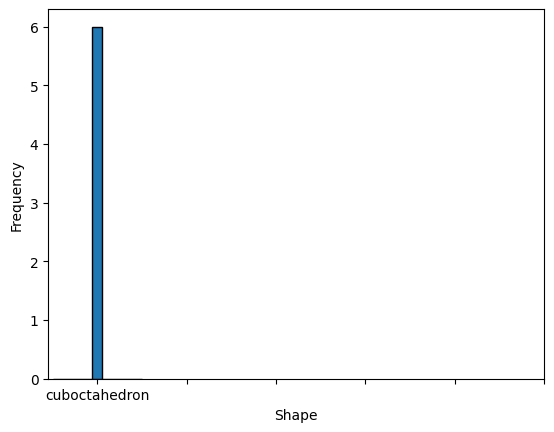

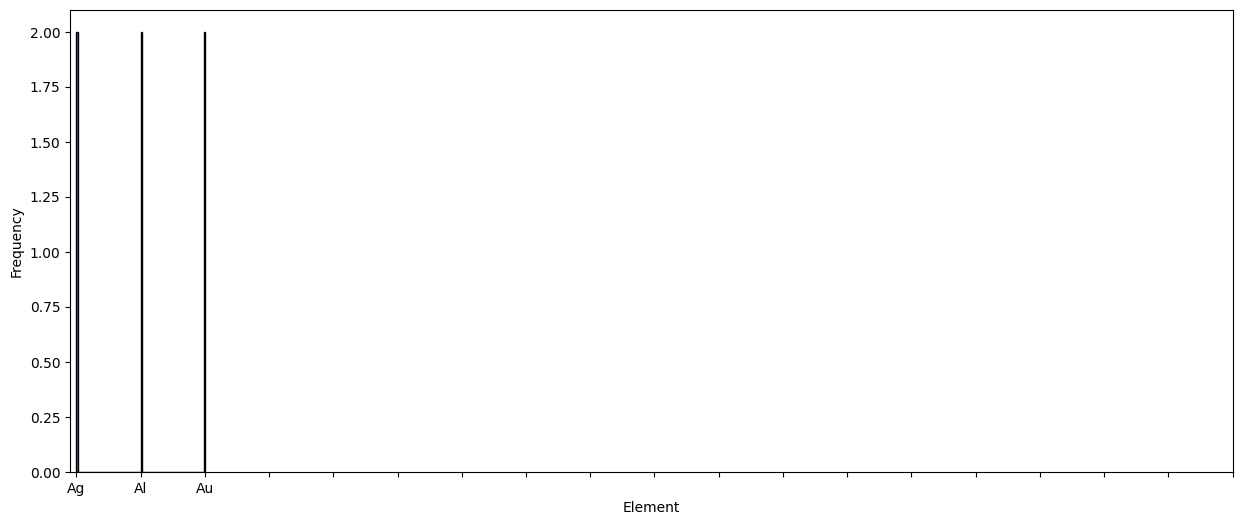

In [32]:

# On va creer un graph qui permet de forme la distribution des formes de notre data frame
import matplotlib.pyplot as plt
# Créer la figure et les axes
fig, ax = plt.subplots()

# Tracer l'histogramme
ax.hist(data['Shape'], bins=9,edgecolor='black')

# Ajouter des labels aux axes
ax.set_xlabel('Shape')
ax.set_ylabel('Frequency')

# Personnaliser les intervalles de l'axe des x
x_ticks = range(0, 6)  # Plage de 0 à 6
plt.xticks(x_ticks)

# Afficher la figure
plt.show()
#--------------------------------------------------------

# On va creer un graph qui permet de forme la distribution des éléments de notre data frame

import matplotlib.pyplot as plt
# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(15,6))


# Tracer l'histogramme
ax.hist(data['Element'], bins=100,edgecolor='black')

# Ajouter des labels aux axes
ax.set_xlabel('Element')
ax.set_ylabel('Frequency')


# Personnaliser les intervalles de l'axe des x
x_ticks = range(0, 19)  # Plage de 0 à 50
plt.xticks(x_ticks)


# Afficher la figure

plt.show()